Import Dependencies

In [3]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Document, Prefetch, FusionQuery, Filter, FieldCondition, MatchText
from qdrant_client import models

from langsmith import traceable, get_current_run_tree


from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages import convert_to_openai_messages, convert_to_messages

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

from utils.utils import  format_ai_message, get_tool_descriptions

/Users/camilo/retrieval_rec_amazon/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Query Expansion Parallel Execution

In [4]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    question_relevant: bool = False
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

#### Query Expansion /Rewriting Node

In [5]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [6]:
@traceable(
    name="query_expand_node",
    run_type = "llm",
    metadata = {"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State) ->dict:
    prompt_template = """You are part of a shopping assistant that can answer questions about products in stock.
    
    Instructions:
    -You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
    -The statements should not overlap in context.
    -Be as concise as possible, do not make up synonyms for statements, one statement per piece of context.

    <Question>
    {{ query }}
    </Question>
    """

    template = Template(prompt_template)

    prompt = template.render(
        query = state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model = "gpt-4.1-mini",
        response_model = QueryExpandResponse,
        messages= [{"role": "system", "content": prompt}],
        temperature = 0.5
    )

    return {
        "expanded_query": response.expanded_query
    }

In [7]:
def query_expand_conditional_edges(state:State):
    send_messages = []

    for query in state.expanded_query:
        send_messages.append(
            Send(
            "retrieve_node",
            {
                "query": query,
                "k":10
            }
        )
    )
    return send_messages
        

#### Retriever Node

In [16]:
@traceable(
    name="embed_query",
    run_type = "embedding",
    metadata = {"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=text,
        model=model,
    )

    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type = "retriever",
   
)
def retrieve_node(state:State,  k=5):
    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-02-hybrid-search",
        prefetch = [
            Prefetch(
                query= query_embedding,
                using = "text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=state['query'],
                    model="qdrant/bm25"
                ),
                using = "bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"


    return {
        "retrieved_context": [formatted_context]
    }

    


Aggregator Node

In [17]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question")

In [18]:
@traceable(
    name="aggregator_node",
    run_type = "llm",
    metadata = {"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) ->dict:

    preprocessed_context = "\n".join(state.retrieved_context)
    prompt_template = f"""You are  a shopping assistant that can answer questions about products in stock.
    
    Instructions:
    -You need to answer the question based on the provided context only.
   -Never used word context and refer to it as the available products.
   -The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

   Context:

   {{ preprocessed_context }}

    Question:
    {{ query }}
    """

    template = Template(prompt_template)

    prompt = template.render(
        preprocessed_context = preprocessed_context,
        query = state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model = "gpt-4.1-mini",
        response_model = AggregatorResponse,
        messages= [{"role": "system", "content": prompt}],
        temperature = 0.5
    )

    return {
        "answer": response.answer
    }

#### User Intent Router Node

In [19]:
class IntentRouterResponse(BaseModel):
    question_relevant: bool
    answer: str

In [20]:
@traceable(
    name="agent_node",
    run_type = "llm",
    metadata= {"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def intent_router_node(state:State):

    prompt_template = f"""You are part of a shopping assistant that can answer questions about products in stock.

    Instructions:
    -You will be given a question and you need to classify it into relevant or not relevant.
    -If the question is not relevant, return False in field "question_relevant" and set "answer" to explain why it is not relevant.
    -If the question is relevant, return True in field "question_relevant" and set "answer" to "".
    - You should only answer questions about products in stock. If the question is not about products in stock, you should ask for clarification.

    <Question>
    {{ query }}
    </Question>
    
    """

    template = Template(prompt_template)

    prompt = template.render(
        query = state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model = "gpt-4.1-mini",
        response_model = IntentRouterResponse,
        messages = [{"role": "system", "content": prompt}],
        temperature = 0.5
    )

    return {
        "question_relevant": response.question_relevant,
        "answer": response.answer
    }

In [21]:
def intent_router_conditional_edfges(state: State):

    if state.question_relevant:
        return "query_expand_node"
    else:
        return "end"

In [22]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)
workflow.add_node("intent_router_node", intent_router_node)

workflow.add_edge(START, "intent_router_node")
workflow.add_conditional_edges("query_expand_node", query_expand_conditional_edges)
workflow.add_conditional_edges(
    "intent_router_node", 
    intent_router_conditional_edfges,
    {
        "query_expand_node": "query_expand_node",
        "end": END
    })
workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

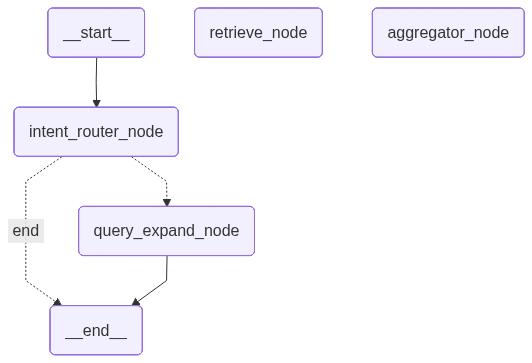

In [23]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
query = "Can I get a table for my kid, a watch for me and a laptop for my wife and a waterproof speaker for our party next week?"
initial_state = {
    "initial_query": query
}


In [25]:
result = graph.invoke(initial_state)

In [26]:
result

{'expanded_query': ['table for kids',
  'watch for adults',
  'laptop for women',
  'waterproof speaker for parties'],
 'retrieved_context': ['- ID: B0C3XYD574, rating: 4.4, description: ROWT Tablet for Kids 10 inch Kids Tablet 2GB RAM 32GB ROM Android 11 6000mAh Wi-Fi, Bluetooth, Kid-Proof Case(Blue) 【Kids\' Safety & Parental Controls】Looking for a safe tablet that\'s easy for your kids to use? This 10-inch tablet for kids is GMS-certified, has password protection, a content filter, and a one-button lock screen, making it easier for parents to keep an eye on their kids activities and learning. 【Creative Educational Content】Our kids tablet provides access to a range of age-appropriate creative kids content such as drawing, educational games, eBooks, learning videos, math tools, and much more! Learning through play is best for kids to understand the world. 【Powerful Configuration & Full Access to Google】This Android 11 kids tablet has an HD 1280x800 IPS touchscreen, 1.6 GHz Quad-Core pr

In [28]:
print(result['answer'])

The available product is the Samsung Galaxy A14 5G with 64GB storage and 4GB RAM in the color Black. Detailed specifications include:

- Model: Samsung Galaxy A14 5G
- Storage Capacity: 64GB
- RAM: 4GB
- Color: Black
- Network: 5G capable

This model offers a balance of storage and memory suitable for everyday tasks and 5G connectivity for faster network speeds.


In [29]:
query = "What is the weather for today?"
initial_state = {
    "initial_query": query
}

In [30]:
result = graph.invoke(initial_state)

In [31]:
result

{'expanded_query': ['weather forecast for today',
  'current weather conditions',
  "today's temperature",
  'weather updates for today'],
 'retrieved_context': ['- ID: B0BZ4N3Z3X, rating: 5.0, description: Waterproof Fogproof Binoculars, High Definition Binoculars for Adults with Low Light Night Vision- TFR-52 \n- ID: B0BJQ3MJW3, rating: 3.5, description: Smart Watch for Android and IOS Phones Women Men, 2023 1.81\'\' Bluetooth Smartwatch Full Touch Screen Answer/Make Call/Text Waterproof Smart Watches, Fitness Tracker Smart Watches for Outdoor Sports 💖【Smart Watch with Answer/Make Call/Message Reminder】: Smartwatch for women has built-in high-quality speakers, fitness tracker watch for android can make/receive calls, receive message alerts, play music, etc. After the connection is successful, Bluetooth watch is synchronized with your mobile phone, you can directly dial the phone number on the watch or answer the phone, and you can synchronize the address book and call history. Vibrat